<a href="https://colab.research.google.com/github/Nannanpeng/Econ_Dynamic_Programming/blob/master/Optimal_growth_model_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

%matplotlib inline

In [2]:
class OptimalGrowthModel:
  def __init__(self, alpha=0.4,
             beta=0.96,       
             mu=0,          # shock location parameter
             s=0.1,        # shock scale parameter
             grid_max=4,
             grid_size=120,
             shock_size=250,
             seed=1234):
    
    self.alpha, self.beta = alpha, beta
    self.y_grids = np.linspace(1e-4, grid_max, grid_size)
    np.random.seed(seed)
    self.mc_shocks = np.exp(mu + s*np.random.randn(shock_size))

  def u(self, c):
    return np.log(c)
  
  def f(self, k):
    return k**self.alpha
  
  def state_action_value(self, c, y, v):
    u, beta, z, f = self.u, self.beta, self.mc_shocks, self.f
    fun_v = interp1d(self.y_grids, v)
    value = self.u(c) + self.beta * fun_v(f(y-c)*z).mean()
    #print(c, y, v, value)
    return value

  def find_best_c(self, y, v):
    obj = lambda c: -self.state_action_value(c, y, v) 
    res = minimize_scalar(obj, bounds=(0, y), method='Bounded')
    return res.x, -res.fun
  
  def T(self, v):
    Tv = np.empty_like(v)
    for i, val in enumerate(self.y_grids):
      Tv[i] = self.find_best_c(val, v)[1]
    return Tv
  
  def fit(self, max_iter=500, tol=1e-5, verbose=True):
    v = np.ones_like(self.y_grids)
    i = 0
    err = 1 + tol
    while i < max_iter and err > tol:
      Tv = self.T(v)
      i += 1
      err = np.max(np.abs(Tv - v))
      v = Tv
      if verbose and i%25==0:
        print(f'Error is {err} at interation {i}.')

    if i == max_iter:
      raise ValueError('Iteration failed.')
    
    if verbose:
      print(f'\nConverged on interation {i}!')

    return v
  
  def OptimalPolicy(self, v):
    policy = np.empty_like(self.y_grids) 
    for i, val in enumerate(self.y_grids):
      policy[i] = self.find_best_c(val, v)[0]
    return policy


In [3]:
%%time

ogm = OptimalGrowthModel()
v = ogm.fit()
policy = ogm.OptimalPolicy(v)

Error is 0.44184738352142006 at interation 25.
Error is 0.15924034540612553 at interation 50.
Error is 0.057389697675713336 at interation 75.
Error is 0.020683058623809814 at interation 100.
Error is 0.007454106422613904 at interation 125.
Error is 0.0026864354818343372 at interation 150.
Error is 0.0009681825277034761 at interation 175.
Error is 0.00034892980431067144 at interation 200.
Error is 0.00012575315589558045 at interation 225.
Error is 4.532102452614595e-05 at interation 250.
Error is 1.6333548451541446e-05 at interation 275.

Converged on interation 288!
CPU times: user 46.6 s, sys: 28.6 ms, total: 46.7 s
Wall time: 46.7 s


In [4]:
def v_star(y, ogm):
  alpha, beta, mu = ogm.alpha, ogm.beta, 0
  left = np.log(1-alpha*beta)/(1-beta)
  middle = (mu+alpha*np.log(alpha*beta))/(1-alpha)*(1/(1-beta) - 1/(1-alpha*beta))
  right = np.log(y)/(1-alpha*beta)
  return left + middle + right

def sigma_star(y, ogm):
  alpha, beta = ogm.alpha, ogm.beta
  return (1-alpha*beta)*y

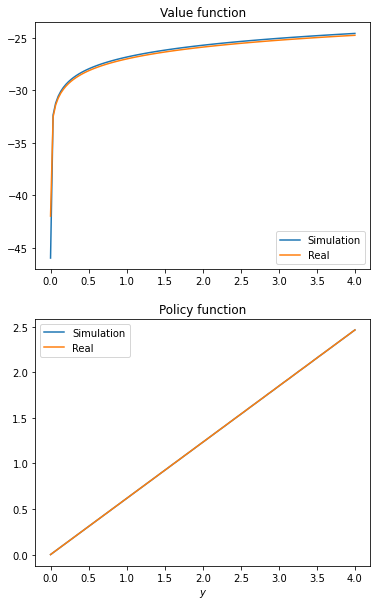

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(6, 10))
for ax, val, title in zip(axes.flatten(), [v, policy], ['Value function', 'Policy function']):
  ax.plot(ogm.y_grids, val, label='Simulation')
  ax.set(title=title)
axes[0].plot(ogm.y_grids, v_star(ogm.y_grids, ogm), label='Real')
axes[1].plot(ogm.y_grids, sigma_star(ogm.y_grids, ogm), label='Real')
axes[0].legend()
axes[1].legend()
axes[1].set(xlabel='$y$');

## Exercise 1

In [6]:
class OptimalGrowthModel2(OptimalGrowthModel):
  def __init__(self, alpha=0.4,
             beta=0.96,       
             mu=0,          # shock location parameter
             s=0.1,        # shock scale parameter
             grid_max=4,
             grid_size=120,
             shock_size=250,
             seed=1234,
             gamma = 1.5):
    super().__init__(alpha, beta, mu, s, grid_max, grid_size, shock_size, seed)
    self.gamma = gamma
  def u(self, c):
    gamma = self.gamma
    return c**(1-gamma)/(1-gamma)

In [7]:
%%time

ogm2 = OptimalGrowthModel2(gamma=1.5)
v2 = ogm2.fit()
policy2 = ogm2.OptimalPolicy(v2)

Error is 1.3416934187295055 at interation 25.
Error is 0.4835408491891968 at interation 50.
Error is 0.17426653451464347 at interation 75.
Error is 0.06280508689729913 at interation 100.
Error is 0.022634747119809617 at interation 125.
Error is 0.008157488548931724 at interation 150.
Error is 0.0029399320908680693 at interation 175.
Error is 0.0010595418733601036 at interation 200.
Error is 0.0003818554126127083 at interation 225.
Error is 0.00013761943705503654 at interation 250.
Error is 4.9597593374528515e-05 at interation 275.
Error is 1.787480982784473e-05 at interation 300.

Converged on interation 315!
CPU times: user 53.5 s, sys: 25 ms, total: 53.5 s
Wall time: 53.6 s


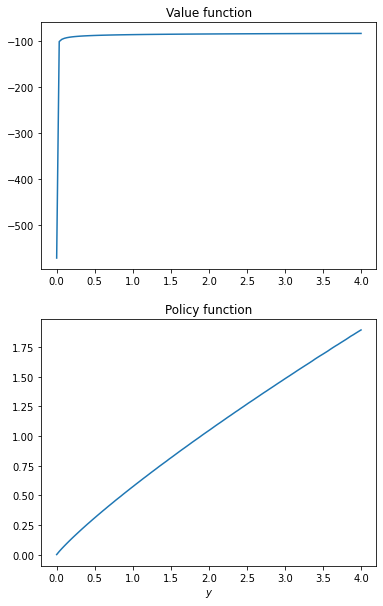

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(6, 10))
for ax, val, title in zip(axes.flatten(), [v2, policy2], ['Value function', 'Policy function']):
  ax.plot(ogm2.y_grids, val, label='Simulation')
  ax.set(title=title)
axes[1].set(xlabel='$y$');